Setup Wine Data

In [1]:
print('Hello')

Hello


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import requests
from io import StringIO

In [3]:
def load_wine_data():
    """
    Download and load the Wine Quality dataset
    Returns: DataFrame with wine quality data
    """
    # URL for the Wine Quality Dataset (Red Wine)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    
    try:
        # Download the data
        response = requests.get(url)
        data = pd.read_csv(StringIO(response.text), sep=';')
        print("Dataset successfully loaded!")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [4]:
def initial_eda(df):
    """
    Perform initial exploratory data analysis
    Args:
        df: pandas DataFrame containing wine quality data
    """
    # Basic information about the dataset
    print("\nDataset Info:")
    print("-" * 40)
    print(df.info())
    
    print("\nBasic Statistics:")
    print("-" * 40)
    print(df.describe())
    
    print("\nMissing Values:")
    print("-" * 40)
    print(df.isnull().sum())
    
    # Distribution of wine quality scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='quality', bins=len(df['quality'].unique()))
    plt.title('Distribution of Wine Quality Scores')
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Wine Features')
    plt.tight_layout()
    plt.show()

In [5]:
def plot_feature_distributions(df):
    """
    Plot distributions of all features
    Args:
        df: pandas DataFrame containing wine quality data
    """
    features = df.columns.tolist()
    n_features = len(features)
    
    # Calculate number of rows and columns for subplots
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 4))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data=df, x=feature, bins=30)
        plt.title(f'{feature} Distribution')
    
    plt.tight_layout()
    plt.show()

In [6]:
def main():
    # Set style for better visualizations
    #plt.style.use('seaborn')
    #sns.set_palette("husl")

    # Set display options
    pd.set_option('display.max_columns', None)
    # Set basic plot style
    plt.style.use('default')
    sns.set_theme()  # Apply seaborn default theme
    
    # Load the data
    df = load_wine_data()
    
    if df is not None:
        # Perform initial EDA
        initial_eda(df)
        
        # Plot feature distributions
        plot_feature_distributions(df)
        
        return df

Dataset successfully loaded!

Dataset Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

Basic Statistics:
-----------------

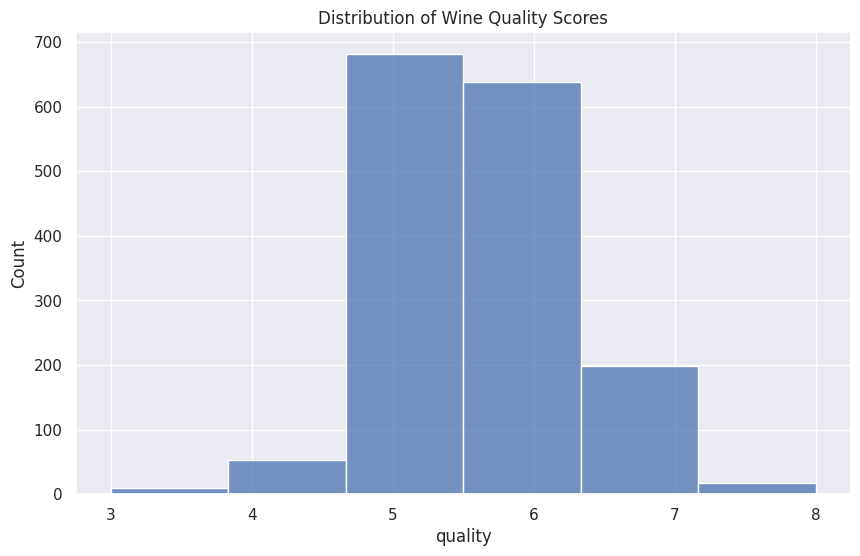

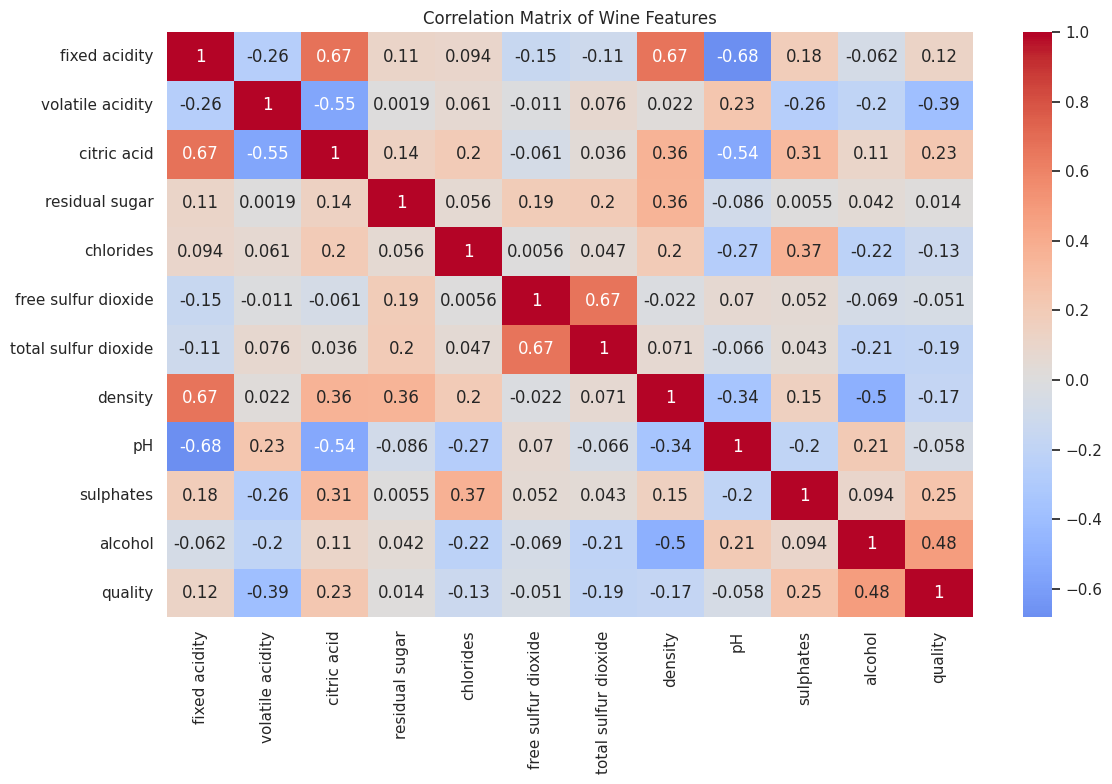

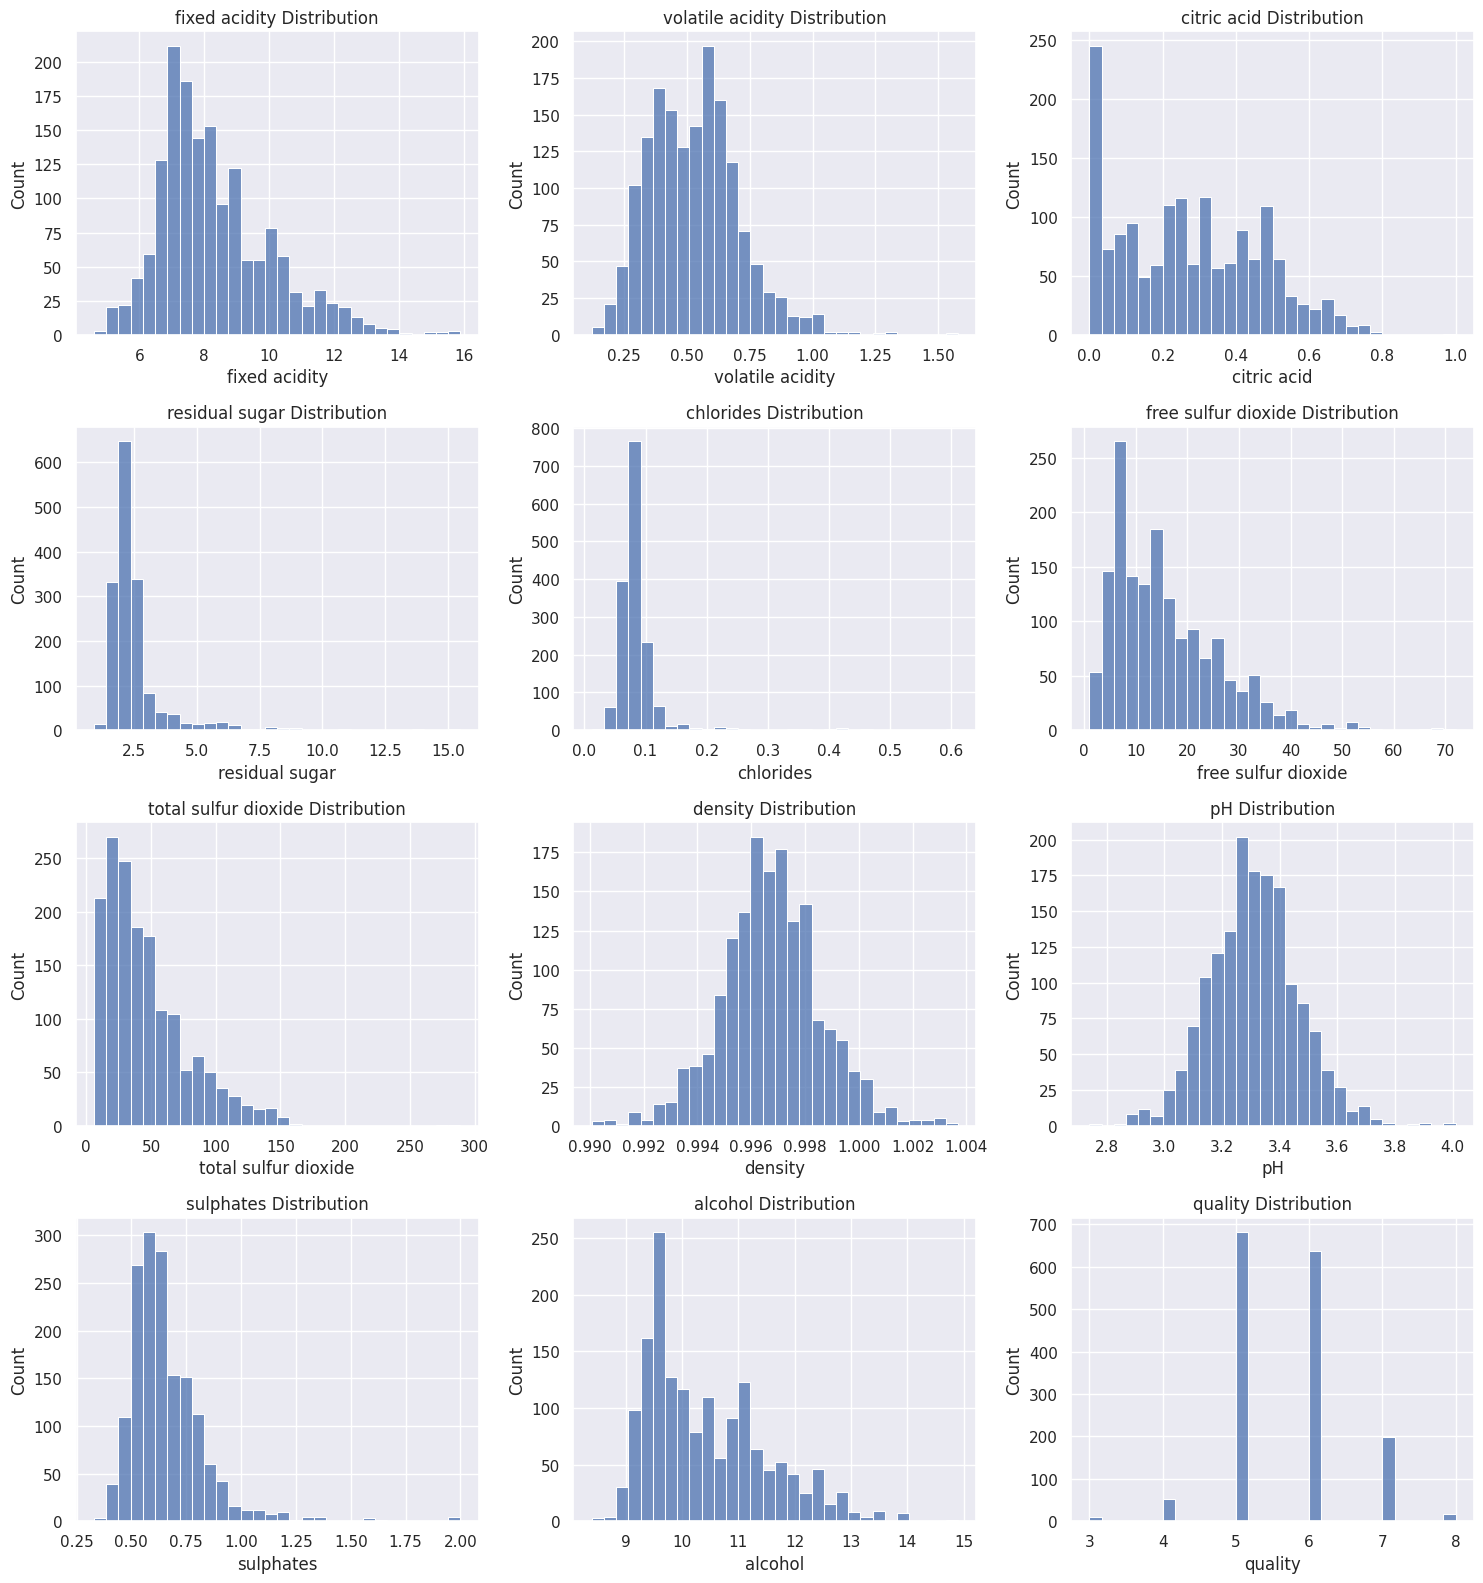

In [7]:
if __name__ == "__main__":
    df = main()

In [8]:
def detect_outliers(df):
    """
    Detect outliers using IQR method
    Returns DataFrame with outlier counts
    """
    outliers_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = len(outliers)
    
    return pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['outlier_count'])

In [9]:

def plot_feature_importance(df, target='quality'):
    """
    Plot feature importance using mutual information
    """
    # Convert target to categorical for mutual information
    y = df[target].astype('category').cat.codes
    X = df.drop(target, axis=1)
    
    # Calculate mutual information
    mi_scores = mutual_info_classif(X, y)
    mi_series = pd.Series(mi_scores, index=X.columns)
    
    # Plot
    plt.figure(figsize=(10, 6))
    mi_series.sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_quality_relationships(df, top_features):
    """
    Plot relationships between top features and quality
    """
    fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))
    
    for idx, feature in enumerate(top_features):
        sns.boxplot(x='quality', y=feature, data=df, ax=axes[idx])
        axes[idx].set_title(f'{feature} vs Quality')
    
    plt.tight_layout()
    plt.show()

In [11]:
def prepare_features(df):
    """
    Prepare features for modeling
    """
    # Create copy to avoid modifying original
    df_prepared = df.copy()
    
    # Handle outliers (you can choose to remove or cap them)
    # Here we'll cap them at 3 std devs
    for column in df_prepared.select_dtypes(include=[np.number]).columns:
        if column != 'quality':  # Don't modify the target
            mean = df_prepared[column].mean()
            std = df_prepared[column].std()
            df_prepared[column] = df_prepared[column].clip(
                lower=mean - 3*std,
                upper=mean + 3*std
            )
    
    # Scale features
    scaler = StandardScaler()
    features = df_prepared.drop('quality', axis=1).columns
    df_prepared[features] = scaler.fit_transform(df_prepared[features])
    
    return df_prepared


Outlier Summary:
                      outlier_count
fixed acidity                    49
volatile acidity                 19
citric acid                       1
residual sugar                  155
chlorides                       112
free sulfur dioxide              30
total sulfur dioxide             55
density                          45
pH                               35
sulphates                        59
alcohol                          13
quality                          28


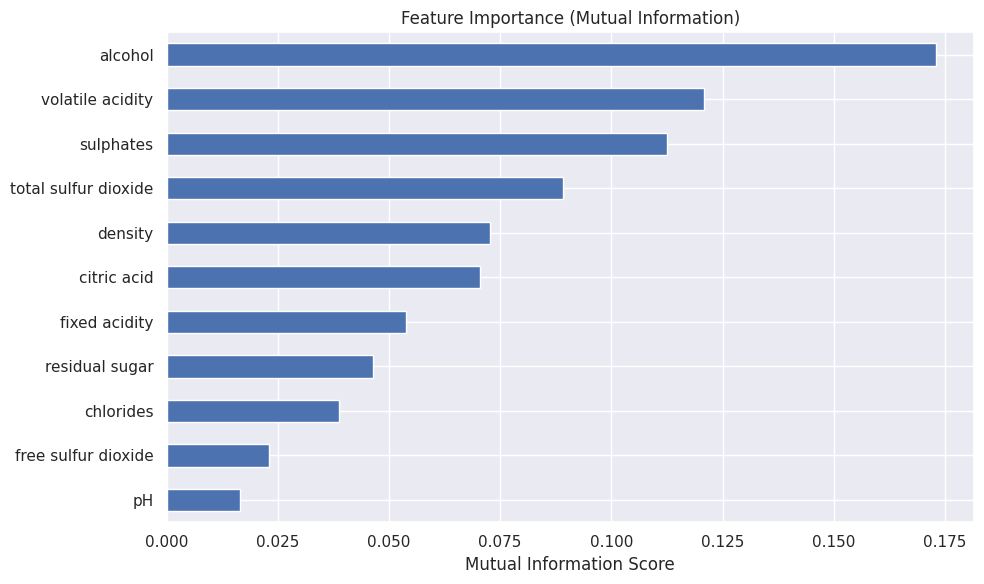

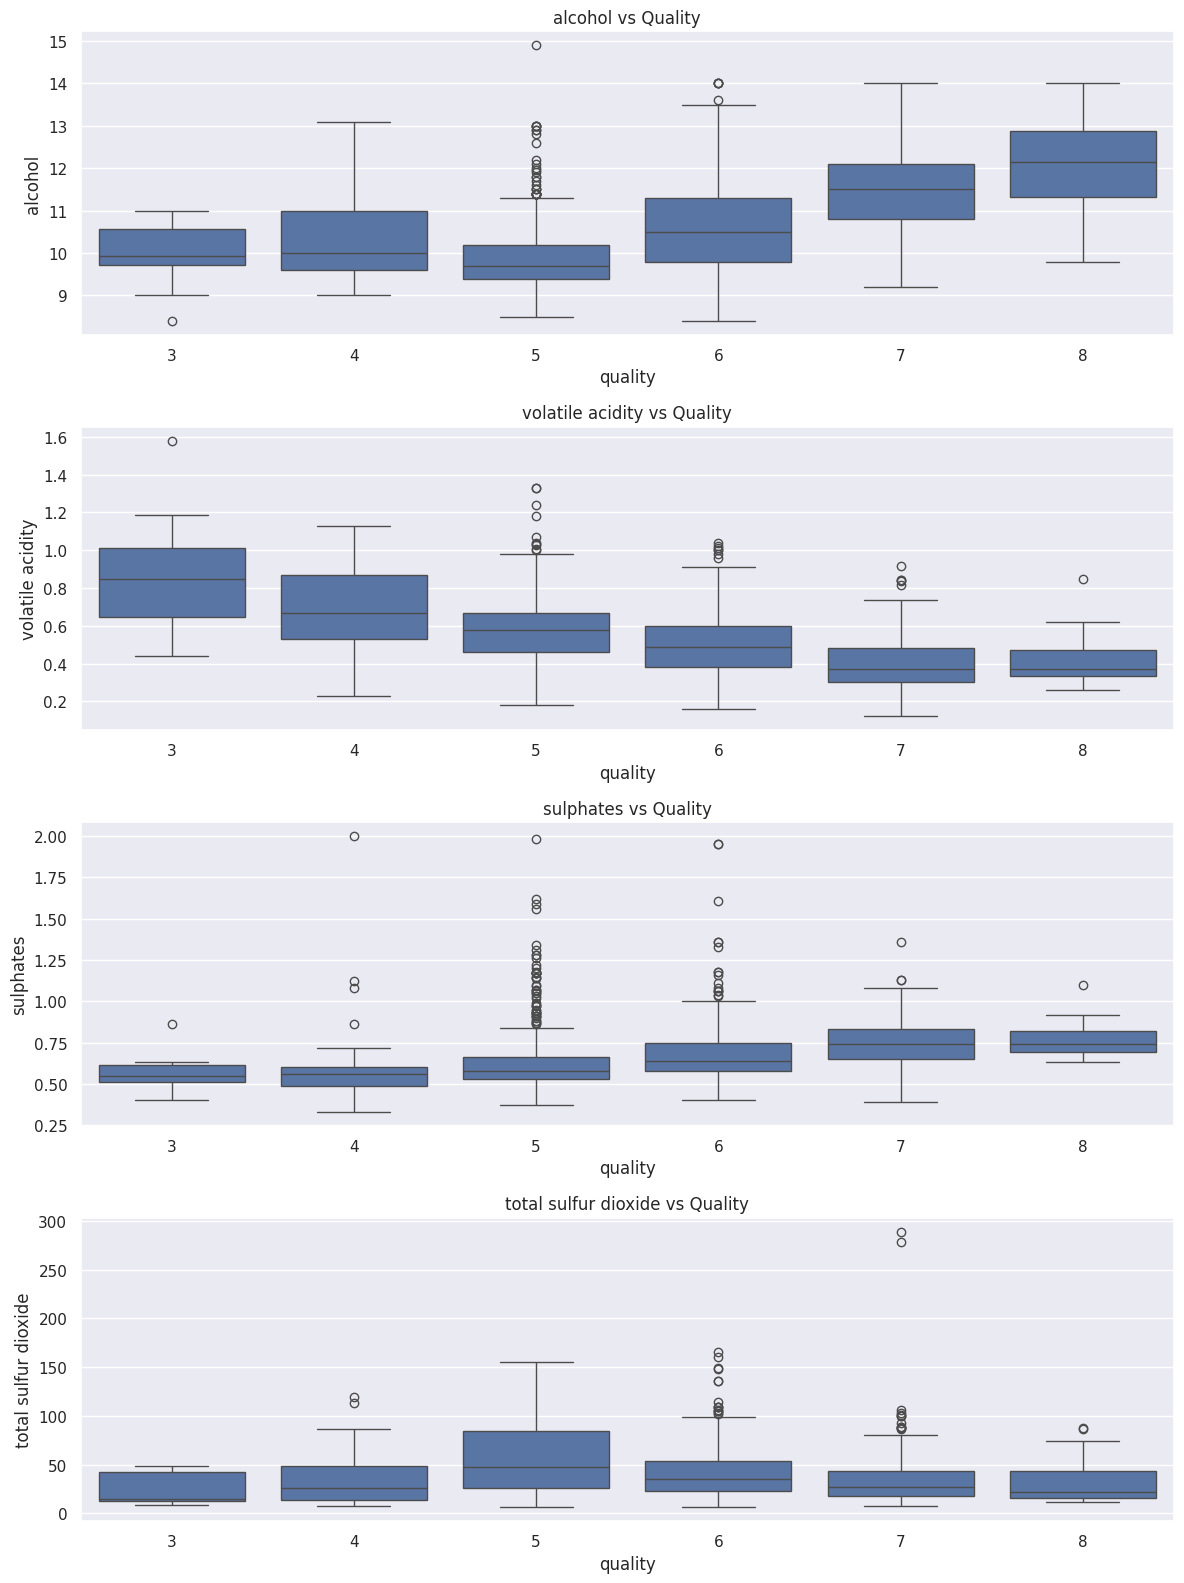

In [12]:
outliers_summary = detect_outliers(df)
print("\nOutlier Summary:")
print(outliers_summary)
    
# 2. Plot feature importance
plot_feature_importance(df)
    
# 3. Plot relationships for top features
top_features = ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide']
plot_quality_relationships(df, top_features)
    
# 4. Prepare features
df_prepared = prepare_features(df)


Data Prep

In [17]:
class WineDataPreparation:
    def __init__(self, df):
        self.df = df.copy()
        self.scaler = StandardScaler()
        
    def handle_outliers(self):
        """
        Handle outliers for specific columns using IQR method
        """
        # Columns identified from our EDA as having significant outliers
        columns_to_cap = ['residual sugar', 'chlorides', 'total sulfur dioxide', 
                         'sulphates']
        
        for column in columns_to_cap:
            Q1 = self.df[column].quantile(0.25)
            Q3 = self.df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap the outliers
            self.df[column] = self.df[column].clip(lower=lower_bound, upper=upper_bound)
            
        return self
    
    def create_features(self):
        """
        Create new features based on domain knowledge and EDA insights
        """
        # Ratio features
        self.df['alcohol_to_density_ratio'] = self.df['alcohol'] / self.df['density']
        self.df['total_acidity'] = self.df['fixed acidity'] + self.df['volatile acidity']
        self.df['sulfur_ratio'] = (self.df['free sulfur dioxide'] / 
                                  self.df['total sulfur dioxide'])
        
        # Log transform features with skewed distributions
        skewed_features = ['residual sugar', 'chlorides', 'total sulfur dioxide', 
                          'free sulfur dioxide', 'sulphates']
        for feature in skewed_features:
            self.df[f'{feature}_log'] = np.log1p(self.df[feature])
            
        return self
    
    def scale_features(self, columns_to_exclude=['quality']):
        """
        Scale features using StandardScaler
        """
        # Get columns to scale (exclude target and any other specified columns)
        columns_to_scale = [col for col in self.df.columns 
                           if col not in columns_to_exclude]
        
        # Fit and transform the scaler
        self.df[columns_to_scale] = self.scaler.fit_transform(
            self.df[columns_to_scale]
        )
        
        return self
    
    def create_train_val_test_split(self, target='quality'):
        """
        Create train/validation/test splits
        """
        # First split: separate test set
        df_train_full, df_test = train_test_split(
            self.df, test_size=0.2, random_state=42
        )
        
        # Second split: create validation set
        df_train, df_val = train_test_split(
            df_train_full, test_size=0.25, random_state=42
        )
        
        # Separate features and target
        y_train = df_train[target]
        y_val = df_val[target]
        y_test = df_test[target]
        
        X_train = df_train.drop(target, axis=1)
        X_val = df_val.drop(target, axis=1)
        X_test = df_test.drop(target, axis=1)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def process(self):
        """
        Run the full preparation pipeline
        """
        self.handle_outliers()
        self.create_features()
        self.scale_features()
        return self.df

In [18]:
def plot_feature_distributions(df, features, n_cols=3):
    """
    Plot distributions of specified features
    """
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution')
    
    # Remove empty subplots
    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()



Dataset shapes:
X_train: (959, 19)
X_val: (320, 19)
X_test: (320, 19)


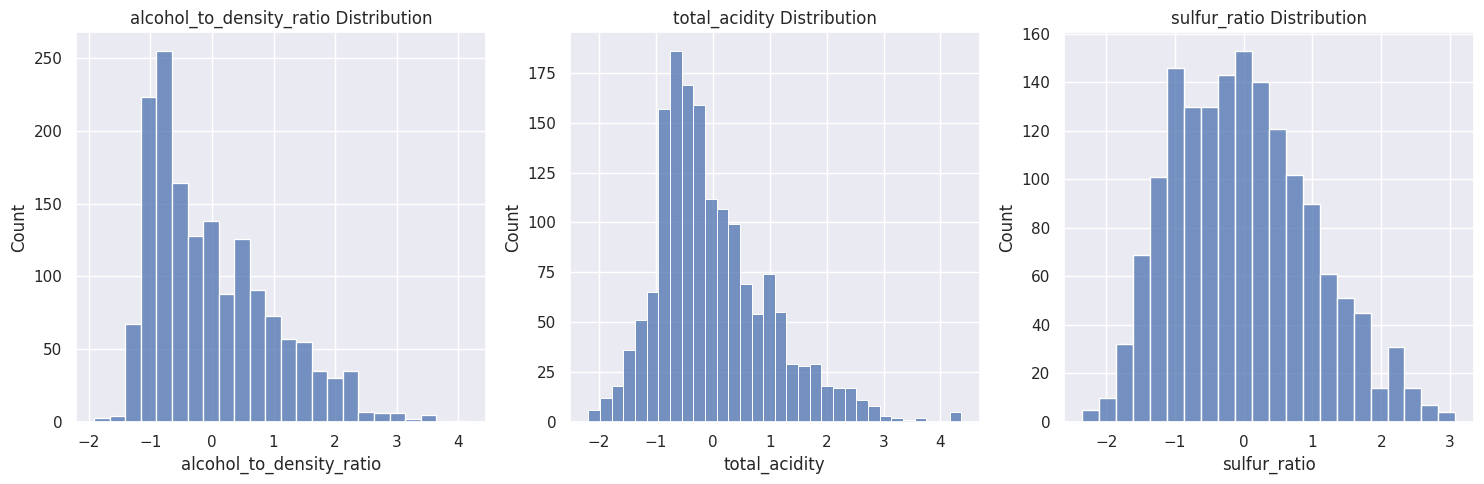

In [19]:
# Initialize and run the preparation pipeline
prep = WineDataPreparation(df)
df_prepared = prep.process()

# Create train/val/test splits
X_train, X_val, X_test, y_train, y_val, y_test = prep.create_train_val_test_split()

# Print shapes to verify splits
print("\nDataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

# Plot distributions of new features
new_features = ['alcohol_to_density_ratio', 'total_acidity', 'sulfur_ratio']
plot_feature_distributions(df_prepared, new_features)

Start Regression


Linear Regression Results:
Training RMSE: 0.6300
Validation RMSE: 0.6597
Training R²: 0.3927
Validation R²: 0.3143


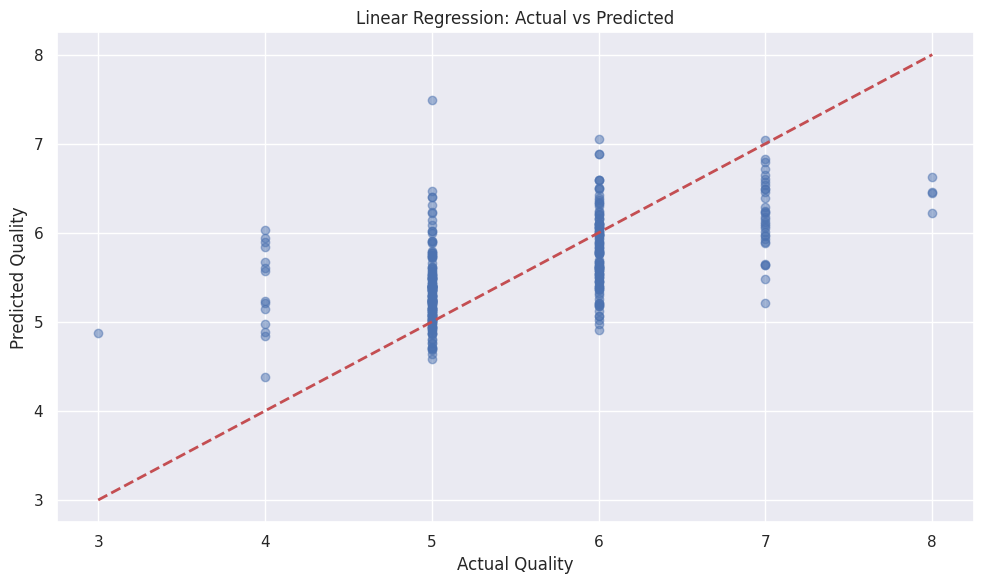

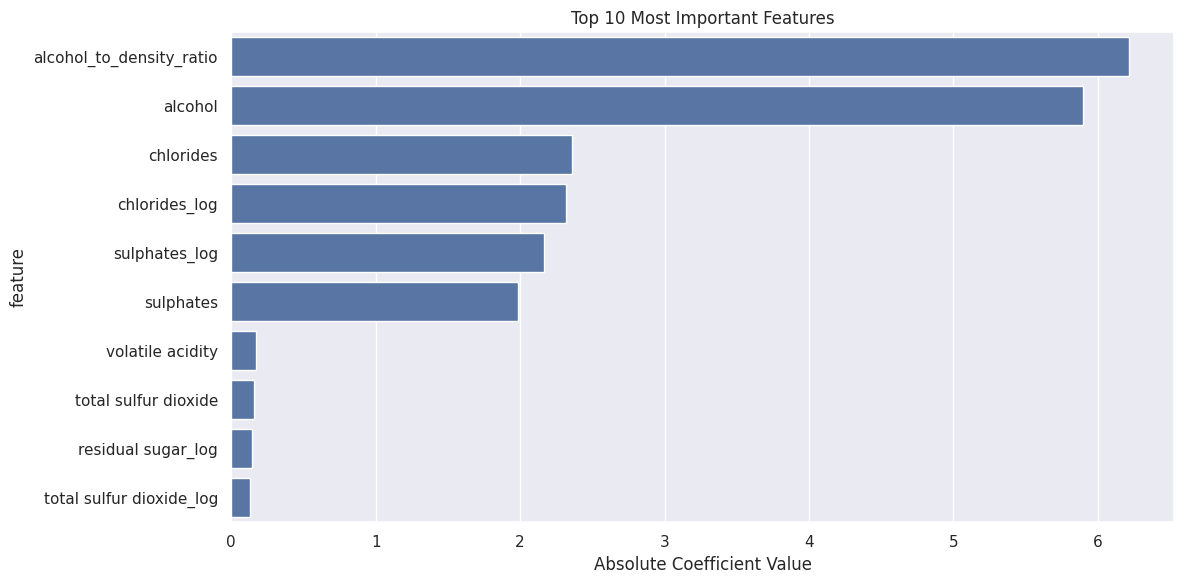


Regularized Models Results:
   alpha  ridge_rmse  lasso_rmse        ridge_model        lasso_model
0    0.1    0.661479    0.684649   Ridge(alpha=0.1)   Lasso(alpha=0.1)
1    1.0    0.664471    0.802243            Ridge()            Lasso()
2   10.0    0.668883    0.802243  Ridge(alpha=10.0)  Lasso(alpha=10.0)


In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityRegression:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
    def train_linear_regression(self):
        """Train and evaluate linear regression model"""
        # Basic Linear Regression
        lr = LinearRegression()
        lr.fit(self.X_train, self.y_train)
        
        # Make predictions
        train_pred = lr.predict(self.X_train)
        val_pred = lr.predict(self.X_val)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(self.y_train, train_pred))
        val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
        train_r2 = r2_score(self.y_train, train_pred)
        val_r2 = r2_score(self.y_val, val_pred)
        
        # Store feature importances
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': np.abs(lr.coef_)
        }).sort_values('importance', ascending=False)
        
        return {
            'model': lr,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'feature_importance': feature_importance
        }
    
    def train_regularized_models(self, alphas=[0.1, 1.0, 10.0]):
        """Train and evaluate Ridge and Lasso regression"""
        results = []
        
        for alpha in alphas:
            # Ridge Regression
            ridge = Ridge(alpha=alpha)
            ridge.fit(self.X_train, self.y_train)
            ridge_val_pred = ridge.predict(self.X_val)
            ridge_rmse = np.sqrt(mean_squared_error(self.y_val, ridge_val_pred))
            
            # Lasso Regression
            lasso = Lasso(alpha=alpha)
            lasso.fit(self.X_train, self.y_train)
            lasso_val_pred = lasso.predict(self.X_val)
            lasso_rmse = np.sqrt(mean_squared_error(self.y_val, lasso_val_pred))
            
            results.append({
                'alpha': alpha,
                'ridge_rmse': ridge_rmse,
                'lasso_rmse': lasso_rmse,
                'ridge_model': ridge,
                'lasso_model': lasso
            })
        
        return pd.DataFrame(results)
    
    def plot_predictions(self, y_true, y_pred, title):
        """Plot actual vs predicted values"""
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Quality')
        plt.ylabel('Predicted Quality')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, feature_importance):
        """Plot feature importance"""
        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Absolute Coefficient Value')
        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Initialize the regression class
    wine_reg = WineQualityRegression(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Train and evaluate linear regression
    lr_results = wine_reg.train_linear_regression()
    print("\nLinear Regression Results:")
    print(f"Training RMSE: {lr_results['train_rmse']:.4f}")
    print(f"Validation RMSE: {lr_results['val_rmse']:.4f}")
    print(f"Training R²: {lr_results['train_r2']:.4f}")
    print(f"Validation R²: {lr_results['val_r2']:.4f}")
    
    # Plot actual vs predicted
    wine_reg.plot_predictions(y_val, lr_results['model'].predict(X_val), 
                            'Linear Regression: Actual vs Predicted')
    
    # Plot feature importance
    wine_reg.plot_feature_importance(lr_results['feature_importance'])
    
    # Train regularized models
    reg_results = wine_reg.train_regularized_models()
    print("\nRegularized Models Results:")
    print(reg_results)


Non-linear Regression Results:

Random Forest:
Training RMSE: 0.2335
Validation RMSE: 0.6042
Training R²: 0.9166
Validation R²: 0.4249

Gradient Boosting:
Training RMSE: 0.4556
Validation RMSE: 0.6403
Training R²: 0.6825
Validation R²: 0.3540


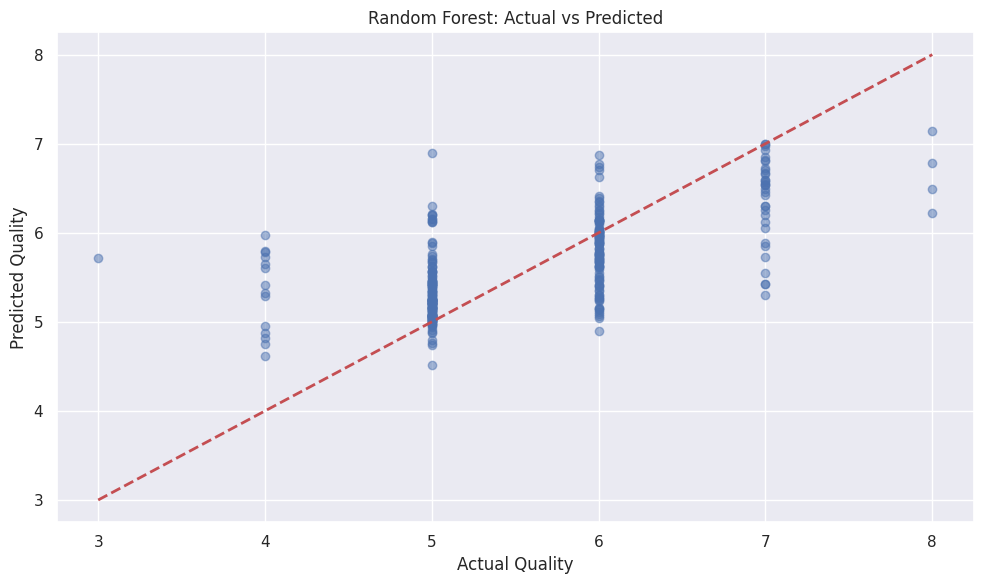

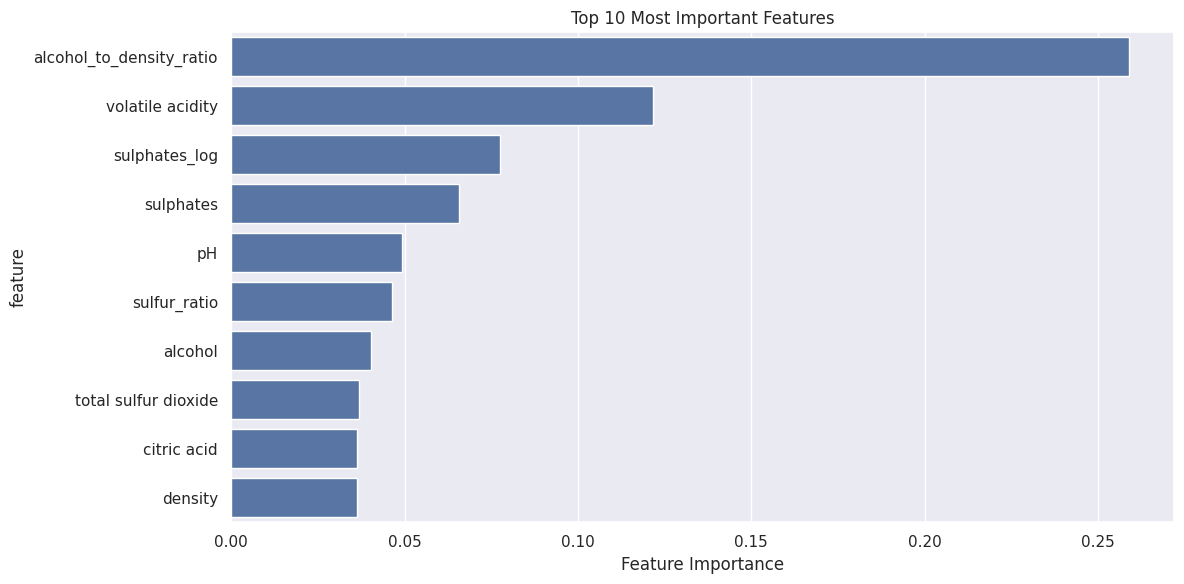


Classification Results:

Random Forest:
Training Accuracy: 1.0000
Validation Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.49      0.57        37
         low       0.83      0.81      0.82       168
      medium       0.66      0.75      0.70       115

    accuracy                           0.75       320
   macro avg       0.73      0.68      0.70       320
weighted avg       0.75      0.75      0.75       320



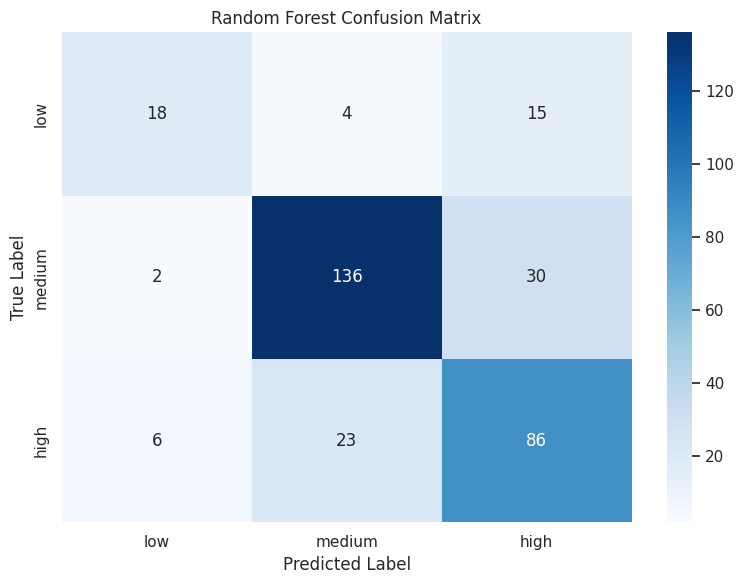


Gradient Boosting:
Training Accuracy: 0.9187
Validation Accuracy: 0.7406

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.49      0.58        37
         low       0.80      0.83      0.81       168
      medium       0.66      0.70      0.68       115

    accuracy                           0.74       320
   macro avg       0.73      0.67      0.69       320
weighted avg       0.74      0.74      0.74       320



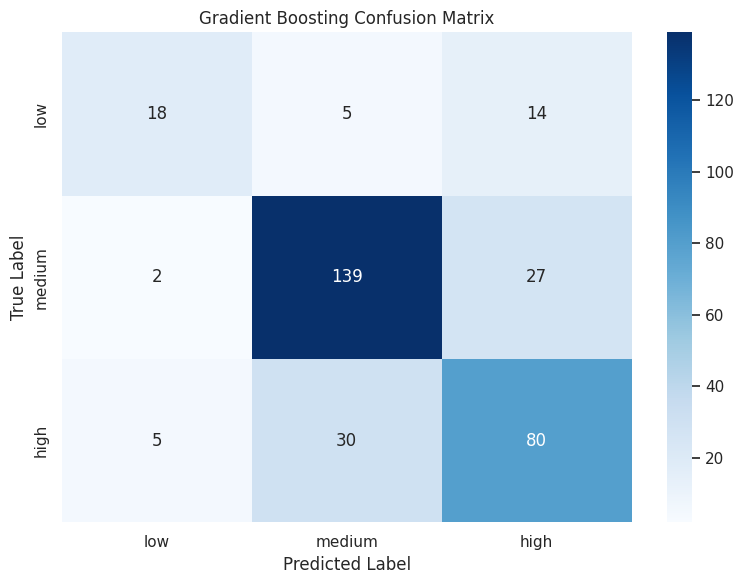

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityAdvancedModels:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        # Create classification labels
        self.y_train_class = self._create_quality_classes(y_train)
        self.y_val_class = self._create_quality_classes(y_val)
        self.y_test_class = self._create_quality_classes(y_test)
    
    def _create_quality_classes(self, y):
        """Convert numeric quality scores to classes"""
        return pd.cut(y, 
                     bins=[0, 5, 6, 10], 
                     labels=['low', 'medium', 'high'],
                     include_lowest=True)
    
    def train_nonlinear_regression(self):
        """Train and evaluate non-linear regression models"""
        models = {
            'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'gradient_boosting': GradientBoostingRegressor(random_state=42)
        }
        
        results = {}
        for name, model in models.items():
            # Train model
            model.fit(self.X_train, self.y_train)
            
            # Make predictions
            train_pred = model.predict(self.X_train)
            val_pred = model.predict(self.X_val)
            
            # Calculate metrics
            results[name] = {
                'model': model,
                'train_rmse': np.sqrt(mean_squared_error(self.y_train, train_pred)),
                'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
                'train_r2': r2_score(self.y_train, train_pred),
                'val_r2': r2_score(self.y_val, val_pred)
            }
            
            # Feature importance for Random Forest
            if name == 'random_forest':
                results['feature_importance'] = pd.DataFrame({
                    'feature': self.X_train.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
        
        return results
    
    def train_classification_models(self):
        """Train and evaluate classification models"""
        models = {
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'gradient_boosting': GradientBoostingClassifier(random_state=42)
        }
        
        results = {}
        for name, model in models.items():
            # Train model
            model.fit(self.X_train, self.y_train_class)
            
            # Make predictions
            train_pred = model.predict(self.X_train)
            val_pred = model.predict(self.X_val)
            
            # Calculate metrics
            results[name] = {
                'model': model,
                'train_accuracy': accuracy_score(self.y_train_class, train_pred),
                'val_accuracy': accuracy_score(self.y_val_class, val_pred),
                'classification_report': classification_report(self.y_val_class, val_pred),
                'confusion_matrix': confusion_matrix(self.y_val_class, val_pred)
            }
        
        return results
    
    def plot_regression_predictions(self, predictions, title):
        """Plot actual vs predicted values for regression"""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_val, predictions, alpha=0.5)
        plt.plot([self.y_val.min(), self.y_val.max()], 
                [self.y_val.min(), self.y_val.max()], 
                'r--', lw=2)
        plt.xlabel('Actual Quality')
        plt.ylabel('Predicted Quality')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, conf_matrix, title):
        """Plot confusion matrix for classification"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['low', 'medium', 'high'],
                   yticklabels=['low', 'medium', 'high'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, feature_importance):
        """Plot feature importance"""
        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(10), 
                   x='importance', y='feature')
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Initialize the advanced models class
    wine_models = WineQualityAdvancedModels(X_train, X_val, X_test, 
                                          y_train, y_val, y_test)
    
    # Train and evaluate non-linear regression models
    reg_results = wine_models.train_nonlinear_regression()
    
    print("\nNon-linear Regression Results:")
    for model_name, results in reg_results.items():
        if model_name != 'feature_importance':
            print(f"\n{model_name.replace('_', ' ').title()}:")
            print(f"Training RMSE: {results['train_rmse']:.4f}")
            print(f"Validation RMSE: {results['val_rmse']:.4f}")
            print(f"Training R²: {results['train_r2']:.4f}")
            print(f"Validation R²: {results['val_r2']:.4f}")
    
    # Plot Random Forest regression predictions
    rf_val_pred = reg_results['random_forest']['model'].predict(wine_models.X_val)
    wine_models.plot_regression_predictions(rf_val_pred, 
                                         'Random Forest: Actual vs Predicted')
    
    # Plot feature importance
    wine_models.plot_feature_importance(reg_results['feature_importance'])
    
    # Train and evaluate classification models
    class_results = wine_models.train_classification_models()
    
    print("\nClassification Results:")
    for model_name, results in class_results.items():
        print(f"\n{model_name.replace('_', ' ').title()}:")
        print(f"Training Accuracy: {results['train_accuracy']:.4f}")
        print(f"Validation Accuracy: {results['val_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results['classification_report'])
        
        # Plot confusion matrix
        wine_models.plot_confusion_matrix(
            results['confusion_matrix'],
            f'{model_name.replace("_", " ").title()} Confusion Matrix'
        )

Baseline RMSE: 0.9699

Linear Regression RMSE: 0.6597


/home/calvin/mlzoomcamp/mlzoomcamp2024-capstone1-wine/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.220e+01, tolerance: 5.184e-02
  model = cd_fast.enet_coordinate_descent(
/home/calvin/mlzoomcamp/mlzoomcamp2024-capstone1-wine/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+00, tolerance: 4.891e-02
  model = cd_fast.enet_coordinate_descent(
/home/calvin/mlzoomcamp/mlzoomcamp2024-capstone1-wine/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might wa


Ridge Results:
Best alpha: 0.1
Validation RMSE: 0.6615

Lasso Results:
Best alpha: 0.001
Validation RMSE: 0.6648

Model Interpretation:

Top 5 most important features:
                     feature  coefficient  abs_coef
11  alcohol_to_density_ratio     6.216383  6.216383
10                   alcohol    -5.899684  5.899684
4                  chlorides    -2.358814  2.358814
15             chlorides_log     2.319396  2.319396
18             sulphates_log     2.164357  2.164357

Error Statistics:
mean_error: -0.0605
std_error: 0.6579
max_error: 2.4949
rmse: 0.6597


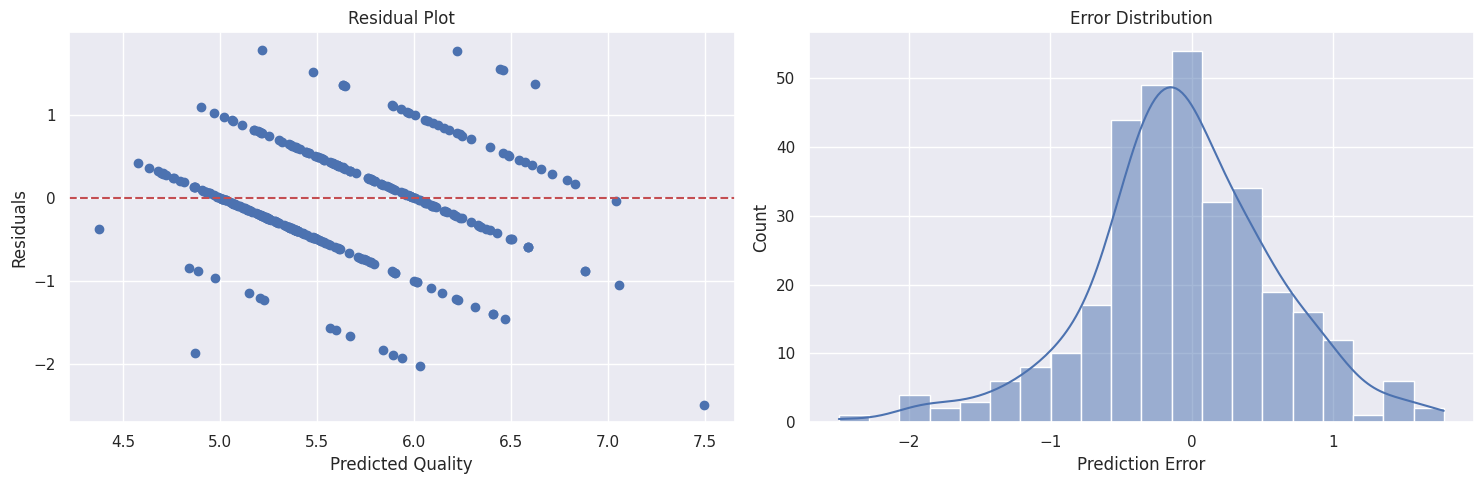

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityRegressionComplete:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
    def create_baseline(self):
        """Create baseline model predicting mean value"""
        mean_prediction = np.mean(self.y_train)
        baseline_pred = np.full_like(self.y_val, mean_prediction)
        baseline_rmse = np.sqrt(mean_squared_error(self.y_val, baseline_pred))
        return {
            'prediction': mean_prediction,
            'rmse': baseline_rmse
        }
    
    def detailed_rmse_analysis(self, y_true, y_pred):
        """Analyze RMSE by quality levels"""
        df = pd.DataFrame({
            'true': y_true,
            'pred': y_pred,
            'error': y_true - y_pred
        })
        
        # Calculate RMSE by quality level
        rmse_by_quality = df.groupby('true').apply(
            lambda x: np.sqrt(mean_squared_error(x['true'], x['pred']))
        )
        
        # Calculate error statistics
        error_stats = {
            'mean_error': df['error'].mean(),
            'std_error': df['error'].std(),
            'max_error': df['error'].abs().max(),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
        }
        
        return rmse_by_quality, error_stats
    
    def tune_regularization(self):
        """Tune Ridge and Lasso regularization"""
        alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        models = {
            'ridge': Ridge(),
            'lasso': Lasso()
        }
        
        best_models = {}
        for name, model in models.items():
            # Grid search with cross-validation
            grid = GridSearchCV(
                model,
                {'alpha': alphas},
                cv=5,
                scoring='neg_root_mean_squared_error'
            )
            grid.fit(self.X_train, self.y_train)
            
            # Get best model
            best_models[name] = {
                'model': grid.best_estimator_,
                'alpha': grid.best_params_['alpha'],
                'rmse': -grid.best_score_
            }
            
            # Predictions with best model
            val_pred = grid.best_estimator_.predict(self.X_val)
            best_models[name]['val_rmse'] = np.sqrt(
                mean_squared_error(self.y_val, val_pred)
            )
        
        return best_models
    
    def model_interpretation(self, model, feature_names):
        """Interpret model coefficients"""
        if hasattr(model, 'coef_'):
            coeffs = pd.DataFrame({
                'feature': feature_names,
                'coefficient': model.coef_
            })
            coeffs['abs_coef'] = abs(coeffs['coefficient'])
            return coeffs.sort_values('abs_coef', ascending=False)
        return None
    
    def plot_prediction_error_analysis(self, y_true, y_pred):
        """Plot detailed error analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Residual plot
        residuals = y_true - y_pred
        ax1.scatter(y_pred, residuals)
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.set_xlabel('Predicted Quality')
        ax1.set_ylabel('Residuals')
        ax1.set_title('Residual Plot')
        
        # Error distribution
        sns.histplot(residuals, kde=True, ax=ax2)
        ax2.set_title('Error Distribution')
        ax2.set_xlabel('Prediction Error')
        
        plt.tight_layout()
        plt.show()
    
    def compare_all_models(self):
        """Compare all regression models"""
        # Get baseline
        baseline = self.create_baseline()
        print(f"Baseline RMSE: {baseline['rmse']:.4f}")
        
        # Train and evaluate linear regression
        lr = LinearRegression()
        lr.fit(self.X_train, self.y_train)
        lr_pred = lr.predict(self.X_val)
        lr_rmse = np.sqrt(mean_squared_error(self.y_val, lr_pred))
        print(f"\nLinear Regression RMSE: {lr_rmse:.4f}")
        
        # Get regularized models
        reg_models = self.tune_regularization()
        for name, results in reg_models.items():
            print(f"\n{name.title()} Results:")
            print(f"Best alpha: {results['alpha']}")
            print(f"Validation RMSE: {results['val_rmse']:.4f}")
        
        # Model interpretation
        print("\nModel Interpretation:")
        coef_importance = self.model_interpretation(lr, self.X_train.columns)
        print("\nTop 5 most important features:")
        print(coef_importance.head())
        
        # Error analysis
        rmse_by_quality, error_stats = self.detailed_rmse_analysis(
            self.y_val, lr_pred
        )
        print("\nError Statistics:")
        for stat, value in error_stats.items():
            print(f"{stat}: {value:.4f}")
        
        return {
            'baseline': baseline,
            'linear_regression': {'model': lr, 'rmse': lr_rmse},
            'regularized': reg_models
        }

# Example usage:
if __name__ == "__main__":
    # Initialize the regression analysis
    wine_reg = WineQualityRegressionComplete(X_train, X_val, X_test, 
                                           y_train, y_val, y_test)
    
    # Run complete analysis
    results = wine_reg.compare_all_models()
    
    # Plot error analysis for best model
    best_model = results['linear_regression']['model']
    val_pred = best_model.predict(wine_reg.X_val)
    wine_reg.plot_prediction_error_analysis(wine_reg.y_val, val_pred)

In [24]:
# First, let's check what features are available
print("Available features:")
print(X_train.columns.tolist())

Available features:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'alcohol_to_density_ratio', 'total_acidity', 'sulfur_ratio', 'residual sugar_log', 'chlorides_log', 'total sulfur dioxide_log', 'free sulfur dioxide_log', 'sulphates_log']


Available features:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'alcohol_to_density_ratio', 'total_acidity', 'sulfur_ratio', 'residual sugar_log', 'chlorides_log', 'total sulfur dioxide_log', 'free sulfur dioxide_log', 'sulphates_log']

Checking for collinear features...
Removing 7 collinear features: ['alcohol_to_density_ratio', 'total_acidity', 'residual sugar_log', 'chlorides_log', 'total sulfur dioxide_log', 'free sulfur dioxide_log', 'sulphates_log']

Adding polynomial features (degree=2) for: ['alcohol', 'volatile acidity', 'sulphates']
Added 6 polynomial features
Current features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'sulfur_ratio', 'alcohol^2', 'alcohol volatile acidity', 'alcohol sulphates', 'volatile acidity^2', 'vola

Best alpha: 10.0
Validation RMSE: 0.6679
Validation R²: 0.2972

Top 10 most important features:
                 feature  coefficient
9              sulphates     0.246824
10               alcohol     0.228257
1       volatile acidity     0.171212
17           sulphates^2     0.136382
7                density     0.114556
0          fixed acidity     0.084208
6   total sulfur dioxide     0.061220
14     alcohol sulphates     0.057817
8                     pH     0.056107
2            citric acid     0.042016

Tuning Lasso...
Best alpha: 0.01
Validation RMSE: 0.6640
Validation R²: 0.3054

Top 10 most important features:
                 feature  coefficient
10               alcohol     0.268267
9              sulphates     0.214441
1       volatile acidity     0.162019
17           sulphates^2     0.106897
14     alcohol sulphates     0.057265
6   total sulfur dioxide     0.057139
8                     pH     0.054348
7                density     0.041924
4              chlorides     0.

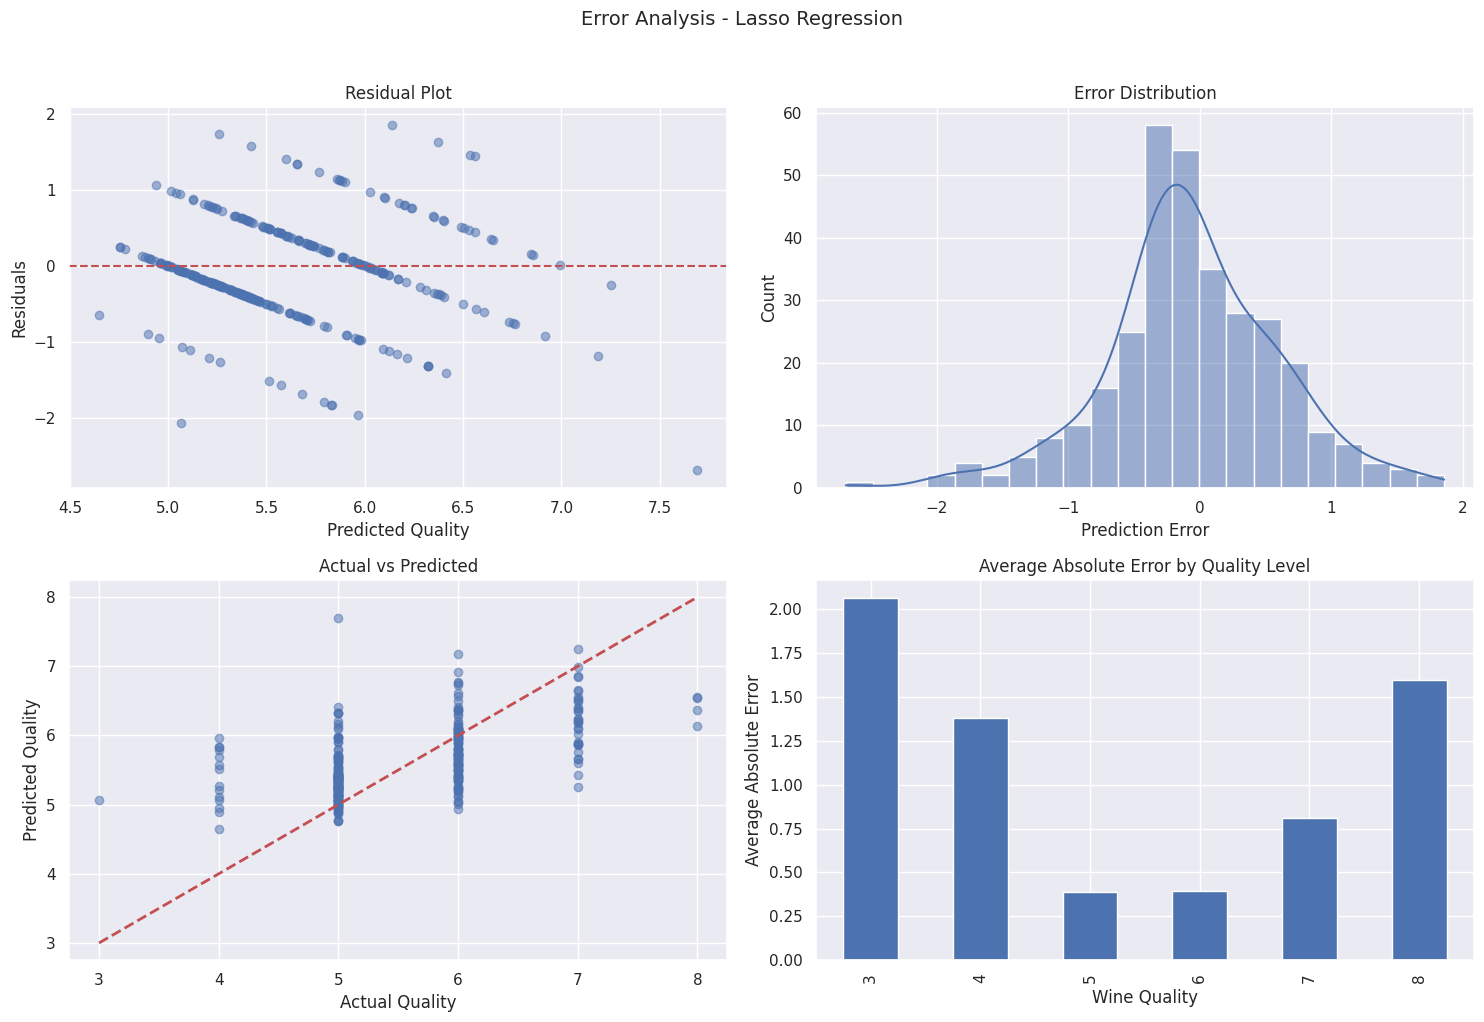

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityRegressionImproved:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Initialize with data and print available features"""
        self.X_train = X_train.copy()
        self.X_val = X_val.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy()
        self.y_val = y_val.copy()
        self.y_test = y_test.copy()
        self.scaler = StandardScaler()
        
        print("Available features:")
        print(self.X_train.columns.tolist())
    
    def remove_collinear_features(self, threshold=0.85):
        """Remove highly correlated features"""
        print("\nChecking for collinear features...")
        corr_matrix = self.X_train.corr().abs()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Find features with correlation above threshold
        to_drop = [column for column in upper.columns 
                  if any(upper[column] > threshold)]
        
        if to_drop:
            print(f"Removing {len(to_drop)} collinear features: {to_drop}")
            self.X_train = self.X_train.drop(to_drop, axis=1)
            self.X_val = self.X_val.drop(to_drop, axis=1)
            self.X_test = self.X_test.drop(to_drop, axis=1)
        else:
            print("No highly collinear features found.")
            
        return self
    
    def add_polynomial_features(self, degree=2):
        """Add polynomial terms for important features"""
        # Use only numerical features that we know exist
        poly_features = ['alcohol', 'volatile acidity', 'sulphates']
        print(f"\nAdding polynomial features (degree={degree}) for: {poly_features}")
        
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        
        # Generate polynomial features for training set
        X_poly_train = poly.fit_transform(self.X_train[poly_features])
        feature_names = poly.get_feature_names_out(poly_features)
        poly_features_df = pd.DataFrame(
            X_poly_train,
            columns=feature_names,
            index=self.X_train.index
        )
        
        # Generate for validation and test sets
        X_poly_val = poly.transform(self.X_val[poly_features])
        X_poly_test = poly.transform(self.X_test[poly_features])
        
        # Add only the interaction and polynomial terms (exclude original features)
        self.X_train = pd.concat([
            self.X_train,
            poly_features_df.iloc[:, len(poly_features):]
        ], axis=1)
        
        self.X_val = pd.concat([
            self.X_val,
            pd.DataFrame(
                X_poly_val[:, len(poly_features):],
                columns=feature_names[len(poly_features):],
                index=self.X_val.index
            )
        ], axis=1)
        
        self.X_test = pd.concat([
            self.X_test,
            pd.DataFrame(
                X_poly_test[:, len(poly_features):],
                columns=feature_names[len(poly_features):],
                index=self.X_test.index
            )
        ], axis=1)
        
        print(f"Added {len(feature_names[len(poly_features):])} polynomial features")
        print("Current features:", self.X_train.columns.tolist())
        return self
    
    def scale_features(self):
        """Scale all features using StandardScaler"""
        print("\nScaling features...")
        
        # Fit and transform training data
        self.X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(self.X_train),
            columns=self.X_train.columns,
            index=self.X_train.index
        )
        
        # Transform validation and test data
        self.X_val_scaled = pd.DataFrame(
            self.scaler.transform(self.X_val),
            columns=self.X_val.columns,
            index=self.X_val.index
        )
        
        self.X_test_scaled = pd.DataFrame(
            self.scaler.transform(self.X_test),
            columns=self.X_test.columns,
            index=self.X_test.index
        )
        
        return self
    
    def tune_models(self):
        """Tune Ridge and Lasso with improved parameters"""
        print("\nTuning regularized models...")
        
        # Parameters for grid search
        alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
        
        models = {
            'ridge': Ridge(max_iter=10000),
            'lasso': Lasso(max_iter=10000, tol=1e-4)
        }
        
        best_models = {}
        for name, model in models.items():
            print(f"\nTuning {name.title()}...")
            
            # Grid search with cross-validation
            grid = GridSearchCV(
                model,
                {'alpha': alphas},
                cv=5,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1
            )
            
            grid.fit(self.X_train_scaled, self.y_train)
            
            # Get best model and predictions
            best_model = grid.best_estimator_
            val_pred = best_model.predict(self.X_val_scaled)
            
            best_models[name] = {
                'model': best_model,
                'alpha': grid.best_params_['alpha'],
                'cv_rmse': -grid.best_score_,
                'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
                'val_r2': r2_score(self.y_val, val_pred)
            }
            
            print(f"Best alpha: {grid.best_params_['alpha']}")
            print(f"Validation RMSE: {best_models[name]['val_rmse']:.4f}")
            print(f"Validation R²: {best_models[name]['val_r2']:.4f}")
            
            # Print feature importance
            feature_importance = pd.DataFrame({
                'feature': self.X_train.columns,
                'coefficient': abs(best_model.coef_)
            }).sort_values('coefficient', ascending=False)
            print("\nTop 10 most important features:")
            print(feature_importance.head(10))
        
        return best_models
    
    def plot_error_analysis(self, predictions, title):
        """Plot improved error analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Residual plot
        residuals = self.y_val - predictions
        axes[0, 0].scatter(predictions, residuals, alpha=0.5)
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_xlabel('Predicted Quality')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residual Plot')
        
        # Error distribution
        sns.histplot(residuals, kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Error Distribution')
        axes[0, 1].set_xlabel('Prediction Error')
        
        # Actual vs Predicted
        axes[1, 0].scatter(self.y_val, predictions, alpha=0.5)
        axes[1, 0].plot([self.y_val.min(), self.y_val.max()],
                       [self.y_val.min(), self.y_val.max()],
                       'r--', lw=2)
        axes[1, 0].set_xlabel('Actual Quality')
        axes[1, 0].set_ylabel('Predicted Quality')
        axes[1, 0].set_title('Actual vs Predicted')
        
        # Error by actual quality
        error_by_quality = pd.DataFrame({
            'actual': self.y_val,
            'error': abs(residuals)
        })
        error_by_quality.groupby('actual')['error'].mean().plot(
            kind='bar', ax=axes[1, 1]
        )
        axes[1, 1].set_title('Average Absolute Error by Quality Level')
        axes[1, 1].set_xlabel('Wine Quality')
        axes[1, 1].set_ylabel('Average Absolute Error')
        
        plt.suptitle(title, y=1.02, size=14)
        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Initialize improved regression analysis
    wine_reg = WineQualityRegressionImproved(X_train, X_val, X_test, 
                                           y_train, y_val, y_test)
    
    # Remove collinear features
    wine_reg.remove_collinear_features(threshold=0.85)
    
    # Add polynomial features
    wine_reg.add_polynomial_features(degree=2)
    
    # Scale features
    wine_reg.scale_features()
    
    # Train and evaluate models
    best_models = wine_reg.tune_models()
    
    # Plot error analysis for best model
    best_model_name = min(best_models, key=lambda x: best_models[x]['val_rmse'])
    best_predictions = best_models[best_model_name]['model'].predict(
        wine_reg.X_val_scaled
    )
    wine_reg.plot_error_analysis(
        best_predictions,
        f'Error Analysis - {best_model_name.title()} Regression'
    )

Training XGBoost model...

Training RMSE: 0.2574
Validation RMSE: 0.6148
Training R²: 0.8986
Validation R²: 0.4044


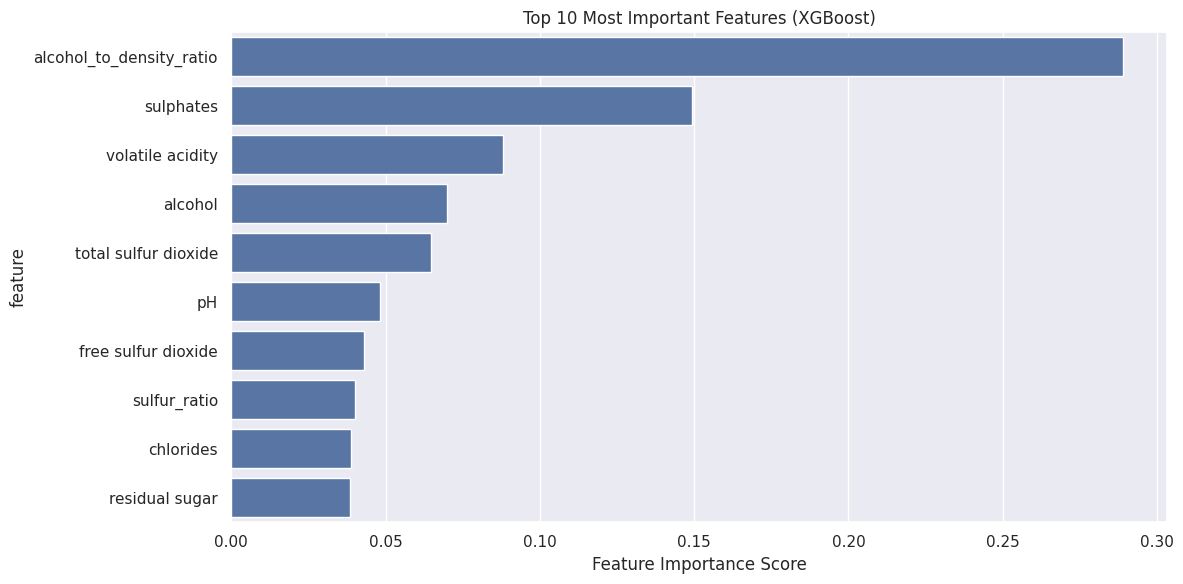


Top 10 most important features:
                     feature  importance
11  alcohol_to_density_ratio    0.288867
9                  sulphates    0.149328
1           volatile acidity    0.087957
10                   alcohol    0.069917
6       total sulfur dioxide    0.064767
8                         pH    0.048167
5        free sulfur dioxide    0.043135
13              sulfur_ratio    0.040163
4                  chlorides    0.038759
3             residual sugar    0.038478


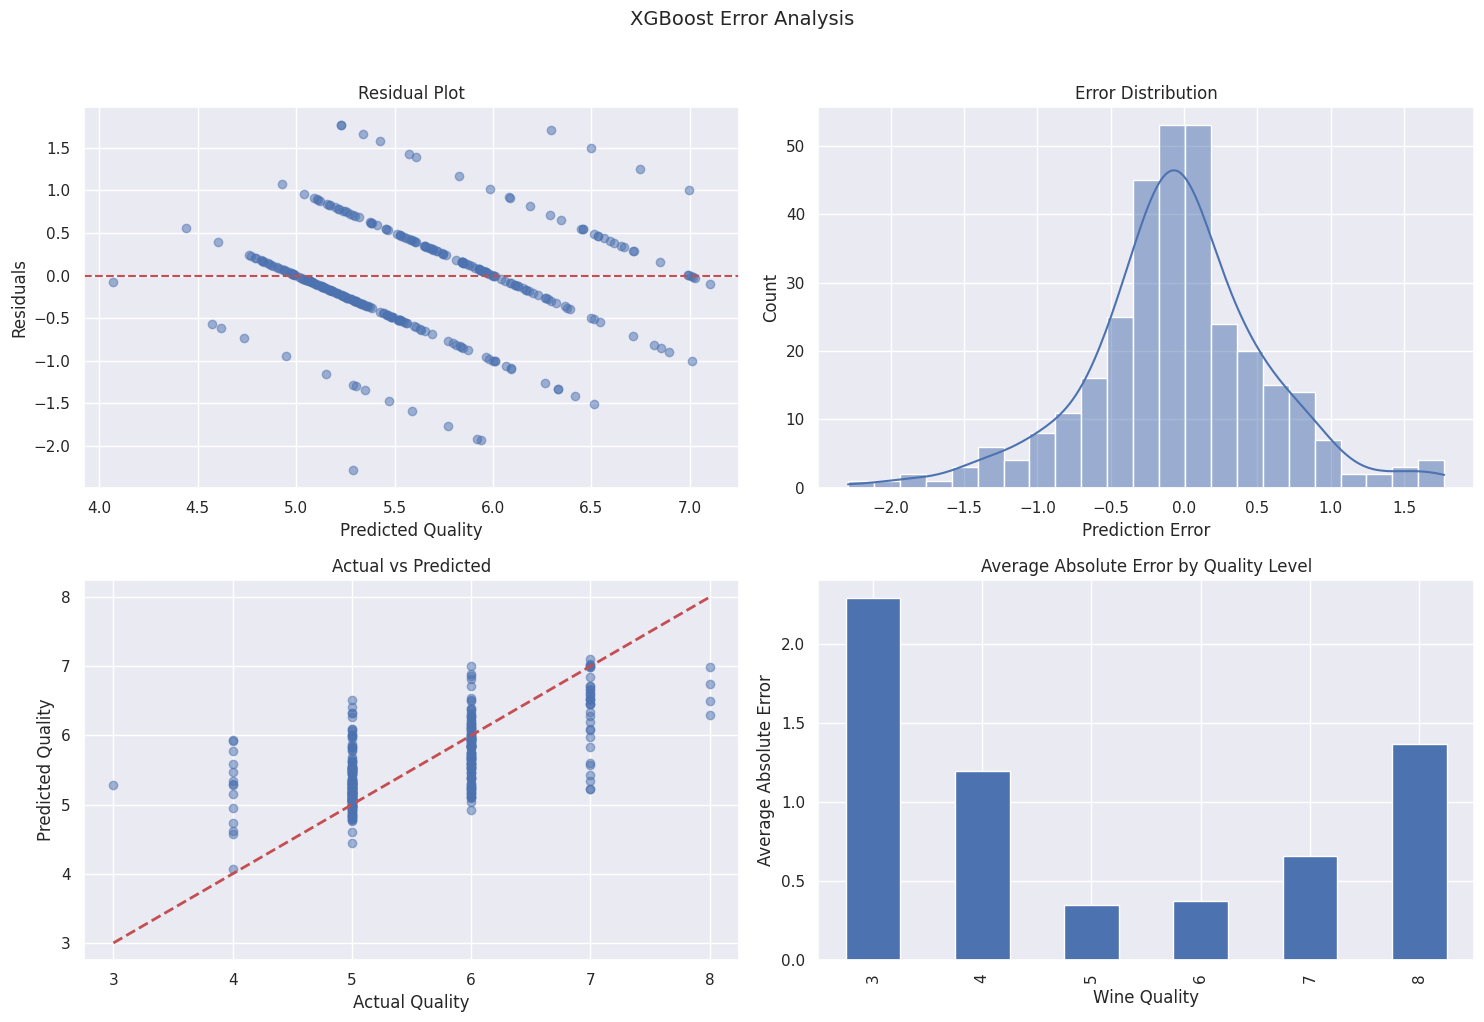


Error Statistics:
Mean Error: -0.0501
Std Error: 0.6128
Max Absolute Error: 2.2899


In [30]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityXGBoost:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
    
    def train_xgboost(self):
        """Train XGBoost with basic parameters"""
        print("Training XGBoost model...")
        
        # Create and train model with basic parameters
        self.model = xgb.XGBRegressor(
            max_depth=4,
            learning_rate=0.1,
            n_estimators=200,
            random_state=42
        )
        
        # Simple fit
        self.model.fit(self.X_train, self.y_train)
        
        # Make predictions
        train_pred = self.model.predict(self.X_train)
        val_pred = self.model.predict(self.X_val)
        
        # Calculate metrics
        results = {
            'model': self.model,
            'train_rmse': np.sqrt(mean_squared_error(self.y_train, train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
            'train_r2': r2_score(self.y_train, train_pred),
            'val_r2': r2_score(self.y_val, val_pred)
        }
        
        print(f"\nTraining RMSE: {results['train_rmse']:.4f}")
        print(f"Validation RMSE: {results['val_rmse']:.4f}")
        print(f"Training R²: {results['train_r2']:.4f}")
        print(f"Validation R²: {results['val_r2']:.4f}")
        
        return results
    
    def plot_feature_importance(self):
        """Plot feature importance from XGBoost model"""
        importance_df = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance_df.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features (XGBoost)')
        plt.xlabel('Feature Importance Score')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        print(importance_df.head(10))
        
        return importance_df
    
    def plot_error_analysis(self, predictions, title):
        """Plot detailed error analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Residual plot
        residuals = self.y_val - predictions
        axes[0, 0].scatter(predictions, residuals, alpha=0.5)
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_xlabel('Predicted Quality')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residual Plot')
        
        # Error distribution
        sns.histplot(residuals, kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Error Distribution')
        axes[0, 1].set_xlabel('Prediction Error')
        
        # Actual vs Predicted
        axes[1, 0].scatter(self.y_val, predictions, alpha=0.5)
        axes[1, 0].plot([self.y_val.min(), self.y_val.max()],
                       [self.y_val.min(), self.y_val.max()],
                       'r--', lw=2)
        axes[1, 0].set_xlabel('Actual Quality')
        axes[1, 0].set_ylabel('Predicted Quality')
        axes[1, 0].set_title('Actual vs Predicted')
        
        # Error by actual quality
        error_by_quality = pd.DataFrame({
            'actual': self.y_val,
            'error': abs(residuals)
        })
        error_by_quality.groupby('actual')['error'].mean().plot(
            kind='bar', ax=axes[1, 1]
        )
        axes[1, 1].set_title('Average Absolute Error by Quality Level')
        axes[1, 1].set_xlabel('Wine Quality')
        axes[1, 1].set_ylabel('Average Absolute Error')
        
        plt.suptitle(title, y=1.02, size=14)
        plt.tight_layout()
        plt.show()
        
        print("\nError Statistics:")
        print(f"Mean Error: {np.mean(residuals):.4f}")
        print(f"Std Error: {np.std(residuals):.4f}")
        print(f"Max Absolute Error: {np.max(np.abs(residuals)):.4f}")

# Example usage:
if __name__ == "__main__":
    # Initialize XGBoost analysis
    wine_xgb = WineQualityXGBoost(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Train XGBoost
    results = wine_xgb.train_xgboost()
    
    # Plot feature importance
    importance_df = wine_xgb.plot_feature_importance()
    
    # Plot error analysis
    val_pred = results['model'].predict(wine_xgb.X_val)
    wine_xgb.plot_error_analysis(val_pred, 'XGBoost Error Analysis')

Creating quality classes...

Class distribution in training set:
quality
low       0.454
medium    0.408
high      0.139
Name: proportion, dtype: float64

Training classification models...

Training logistic...

Logistic Results:
Training Accuracy: 0.6506777893639207
Validation Accuracy: 0.696875

Classification Report:
              precision    recall  f1-score   support

        high       0.58      0.41      0.48        37
         low       0.78      0.82      0.80       168
      medium       0.59      0.61      0.60       115

    accuracy                           0.70       320
   macro avg       0.65      0.61      0.63       320
weighted avg       0.69      0.70      0.69       320


Training random_forest...

Random_forest Results:
Training Accuracy: 1.0
Validation Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

        high       0.68      0.51      0.58        37
         low       0.83      0.81      0.82       168
      medi

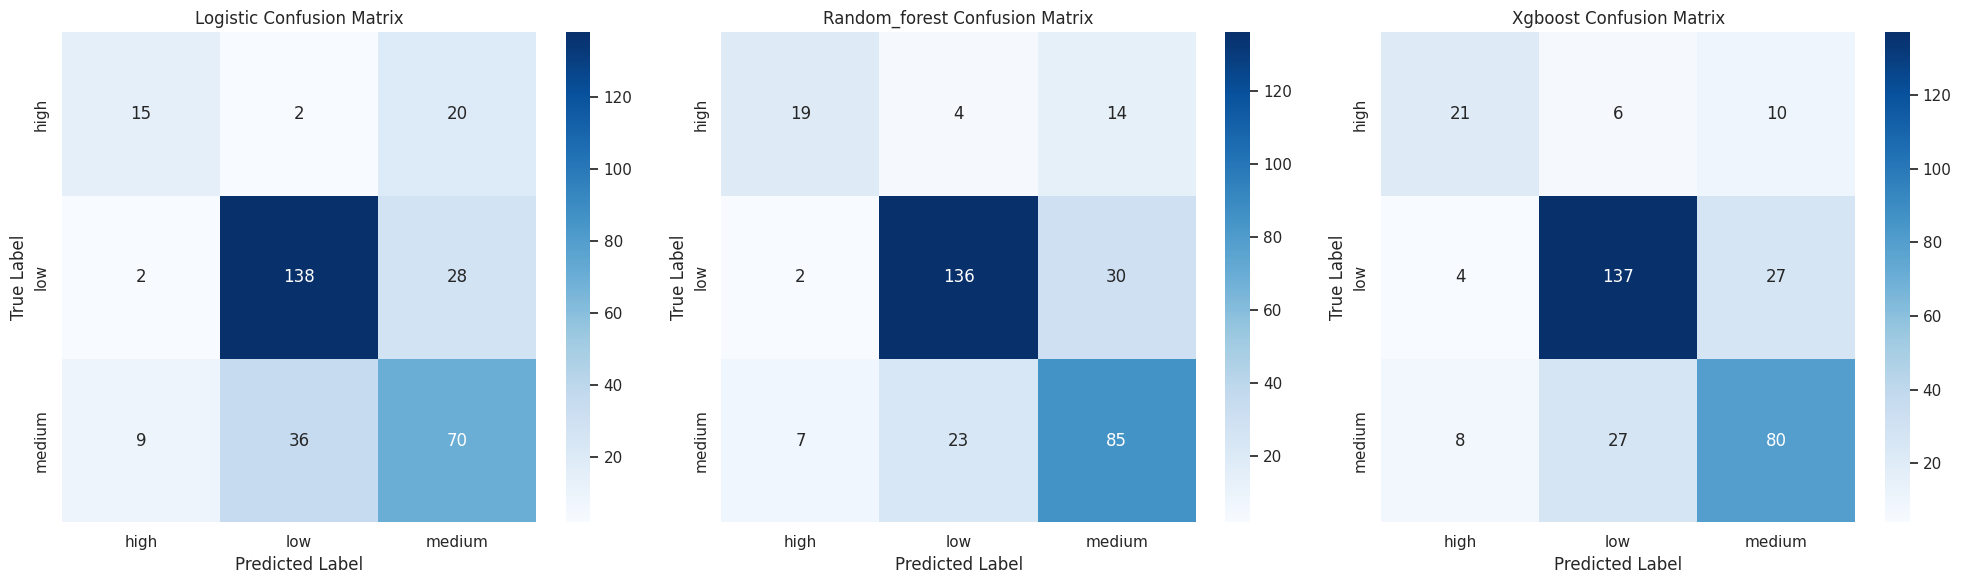

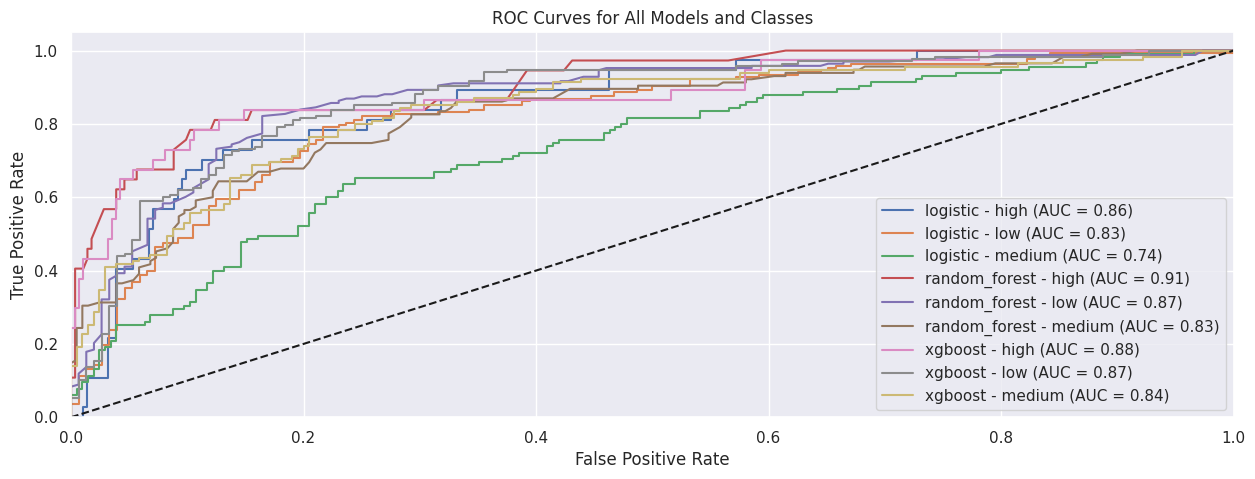

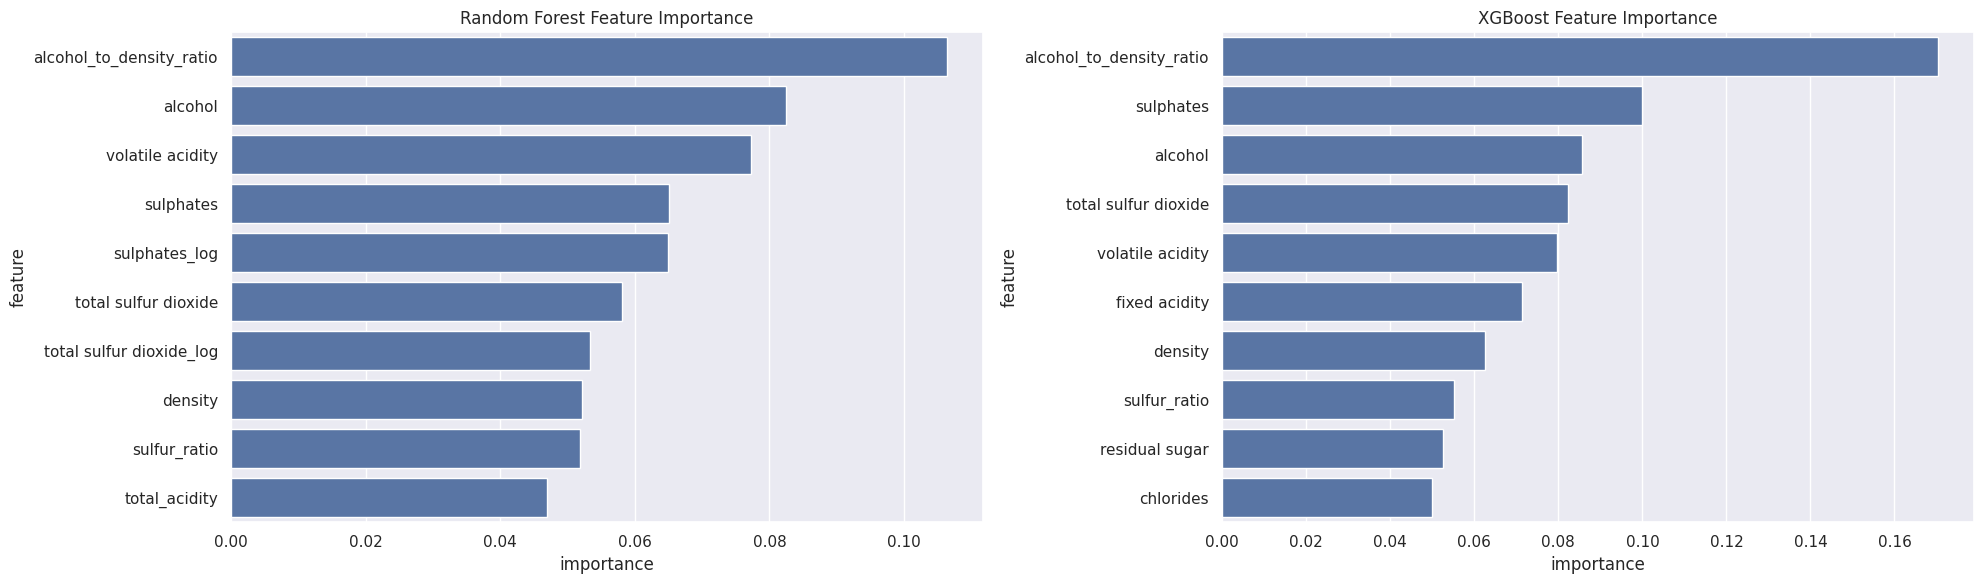

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

class WineQualityClassification:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.models = {}
        self.predictions = {}
        self.le = LabelEncoder()
    
    def create_quality_classes(self):
        """Convert numeric quality scores to classes"""
        print("Creating quality classes...")
        
        def to_class(x):
            if x <= 5:
                return 'low'
            elif x == 6:
                return 'medium'
            else:
                return 'high'
        
        # Convert to classes
        self.y_train_class = self.y_train.apply(to_class)
        self.y_val_class = self.y_val.apply(to_class)
        self.y_test_class = self.y_test.apply(to_class)
        
        # Encode classes
        self.y_train_encoded = self.le.fit_transform(self.y_train_class)
        self.y_val_encoded = self.le.transform(self.y_val_class)
        self.y_test_encoded = self.le.transform(self.y_test_class)
        
        # Print class distribution
        print("\nClass distribution in training set:")
        print(self.y_train_class.value_counts(normalize=True).round(3))
        
        return self
    
    def train_models(self):
        """Train multiple classification models"""
        print("\nTraining classification models...")
        
        # Initialize models
        models = {
            'logistic': LogisticRegression(max_iter=1000, random_state=42),
            'random_forest': RandomForestClassifier(n_estimators=200, 
                                                  random_state=42),
            'xgboost': xgb.XGBClassifier(random_state=42)
        }
        
        # Train and evaluate each model
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(self.X_train, self.y_train_encoded)
            
            # Make predictions
            train_pred = model.predict(self.X_train)
            val_pred = model.predict(self.X_val)
            
            # Store model and predictions
            self.models[name] = model
            self.predictions[name] = {
                'train': train_pred,
                'val': val_pred,
                'train_prob': model.predict_proba(self.X_train),
                'val_prob': model.predict_proba(self.X_val)
            }
            
            # Print performance metrics
            print(f"\n{name.capitalize()} Results:")
            print("Training Accuracy:", 
                  accuracy_score(self.y_train_encoded, train_pred))
            print("Validation Accuracy:", 
                  accuracy_score(self.y_val_encoded, val_pred))
            print("\nClassification Report:")
            print(classification_report(self.y_val_encoded, val_pred,
                                     target_names=self.le.classes_))
        
        return self
    
    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        for idx, (name, preds) in enumerate(self.predictions.items()):
            cm = confusion_matrix(self.y_val_encoded, preds['val'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=self.le.classes_,
                       yticklabels=self.le.classes_)
            axes[idx].set_title(f'{name.capitalize()} Confusion Matrix')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(15, 5))
        
        for name, preds in self.predictions.items():
            # Calculate ROC curve and AUC for each class
            n_classes = len(self.le.classes_)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(
                    (self.y_val_encoded == i).astype(int),
                    preds['val_prob'][:, i]
                )
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Plot ROC curves
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i],
                        label=f'{name} - {self.le.classes_[i]} '
                              f'(AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for All Models and Classes')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance for RF and XGBoost"""
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        
        # Random Forest importance
        rf_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.models['random_forest'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        sns.barplot(data=rf_importance.head(10), x='importance', y='feature',
                   ax=axes[0])
        axes[0].set_title('Random Forest Feature Importance')
        
        # XGBoost importance
        xgb_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.models['xgboost'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        sns.barplot(data=xgb_importance.head(10), x='importance', y='feature',
                   ax=axes[1])
        axes[1].set_title('XGBoost Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        return {'random_forest': rf_importance, 'xgboost': xgb_importance}

# Example usage:
if __name__ == "__main__":
    # Initialize classification analysis
    wine_clf = WineQualityClassification(X_train, X_val, X_test, 
                                       y_train, y_val, y_test)
    
    # Create classes and train models
    wine_clf.create_quality_classes()
    wine_clf.train_models()
    
    # Plot results
    wine_clf.plot_confusion_matrices()
    wine_clf.plot_roc_curves()
    importance_dfs = wine_clf.plot_feature_importance()

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle
from typing import Tuple, Dict

class WineQualityModel:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestClassifier(
            n_estimators=200,
            random_state=42
        )
        self.feature_names = None
    
    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare features including engineering steps"""
        # Create copy to avoid modifying original
        df = df.copy()
        
        # Create engineered features
        df['alcohol_to_density_ratio'] = df['alcohol'] / df['density']
        df['total_acidity'] = df['fixed acidity'] + df['volatile acidity']
        df['sulfur_ratio'] = df['free sulfur dioxide'] / df['total sulfur dioxide']
        
        # Create log transforms for skewed features
        skewed_features = ['residual sugar', 'chlorides', 'total sulfur dioxide', 
                          'free sulfur dioxide', 'sulphates']
        for feature in skewed_features:
            df[f'{feature}_log'] = np.log1p(df[feature])
        
        return df
    
    def create_quality_labels(self, quality: pd.Series) -> pd.Series:
        """Convert numeric quality scores to classes"""
        return pd.cut(quality, 
                     bins=[0, 5, 6, 10], 
                     labels=['low', 'medium', 'high'],
                     include_lowest=True)
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Fit the model pipeline"""
        # Store feature names
        self.feature_names = X.columns.tolist()
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Create quality classes
        y_classes = self.create_quality_labels(y)
        
        # Fit model
        self.model.fit(X_scaled, y_classes)
        
        return self
    
    def predict(self, X: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predict wine quality class and probabilities
        Returns: (predictions, probabilities)
        """
        # Ensure features match training data
        X = X[self.feature_names]
        
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        # Make predictions
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        return predictions, probabilities
    
    def get_feature_importance(self) -> pd.DataFrame:
        """Get feature importance dataframe"""
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df

def train_and_save_model(df: pd.DataFrame, save_path: str = 'wine_model.pkl'):
    """Train and save the final model"""
    # Prepare features
    model = WineQualityModel()
    X = model.prepare_features(df)
    y = df['quality']
    
    # Fit model
    model.fit(X, y)
    
    # Save model
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to {save_path}")
    return model

def load_model(model_path: str) -> WineQualityModel:
    """Load the trained model"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def predict_quality(model: WineQualityModel, wine_data: pd.DataFrame) -> Dict:
    """Make predictions for new wine data"""
    # Prepare features
    X = model.prepare_features(wine_data)
    
    # Make predictions
    predictions, probabilities = model.predict(X)
    
    # Create results dictionary
    results = {
        'predictions': predictions,
        'probabilities': {
            'low': probabilities[:, 0],
            'medium': probabilities[:, 1],
            'high': probabilities[:, 2]
        }
    }
    
    return results

# Example usage:
if __name__ == "__main__":
    # Assuming df is your wine quality dataset
    # Train and save model
    model = train_and_save_model(df, 'wine_model.pkl')
    
    # Example prediction
    # new_wine = pd.DataFrame(...)  # New wine data
    # model = load_model('wine_model.pkl')
    # results = predict_quality(model, new_wine)
    # print("Predicted class:", results['predictions'][0])
    # print("Class probabilities:", results['probabilities'])

Model saved to wine_model.pkl


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle
from typing import Tuple, Dict

class WineQualityModel:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestClassifier(
            n_estimators=200,
            random_state=42
        )
        self.feature_names = None
        self.required_features = [
            'fixed acidity', 'volatile acidity', 'citric acid', 
            'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
        ]
    
    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare features including engineering steps"""
        # Create copy to avoid modifying original
        df = df.copy()
        
        # Verify all required features are present
        missing_features = [feat for feat in self.required_features 
                          if feat not in df.columns]
        if missing_features:
            raise ValueError(f"Missing required features: {missing_features}")
        
        # Create engineered features
        df['alcohol_to_density_ratio'] = df['alcohol'] / df['density']
        df['total_acidity'] = df['fixed acidity'] + df['volatile acidity']
        df['sulfur_ratio'] = (df['free sulfur dioxide'] / 
                            df['total sulfur dioxide'].replace(0, 1))  # Avoid division by zero
        
        # Create log transforms for skewed features
        skewed_features = ['residual sugar', 'chlorides', 'total sulfur dioxide', 
                          'free sulfur dioxide', 'sulphates']
        for feature in skewed_features:
            df[f'{feature}_log'] = np.log1p(df[feature])
        
        return df
    
    def create_quality_labels(self, quality: pd.Series) -> pd.Series:
        """Convert numeric quality scores to classes"""
        return pd.cut(quality, 
                     bins=[0, 5, 6, 10], 
                     labels=['low', 'medium', 'high'],
                     include_lowest=True)
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Fit the model pipeline"""
        # Prepare features
        X_prepared = self.prepare_features(X)
        
        # Store feature names
        self.feature_names = X_prepared.columns.tolist()
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X_prepared)
        
        # Create quality classes
        y_classes = self.create_quality_labels(y)
        
        # Fit model
        self.model.fit(X_scaled, y_classes)
        
        return self
    
    def predict(self, X: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predict wine quality class and probabilities
        Returns: (predictions, probabilities)
        """
        if self.feature_names is None:
            raise ValueError("Model has not been fitted yet!")
        
        # Prepare features
        X_prepared = self.prepare_features(X)
        
        # Select features in the same order as training
        X_prepared = X_prepared[self.feature_names]
        
        # Scale features
        X_scaled = self.scaler.transform(X_prepared)
        
        # Make predictions
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        return predictions, probabilities
    
    def get_feature_importance(self) -> pd.DataFrame:
        """Get feature importance dataframe"""
        if self.feature_names is None:
            raise ValueError("Model has not been fitted yet!")
            
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df

def train_and_save_model(df: pd.DataFrame, save_path: str = 'wine_model.pkl'):
    """Train and save the final model"""
    # Split features and target
    X = df.drop('quality', axis=1)
    y = df['quality']
    
    # Initialize and fit model
    model = WineQualityModel()
    model.fit(X, y)
    
    # Save model
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to {save_path}")
    return model

def load_model(model_path: str) -> WineQualityModel:
    """Load the trained model"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def predict_quality(model: WineQualityModel, wine_data: pd.DataFrame) -> Dict:
    """Make predictions for new wine data"""
    # Make predictions
    predictions, probabilities = model.predict(wine_data)
    
    # Create results dictionary
    results = {
        'predictions': predictions,
        'probabilities': {
            'low': probabilities[:, 0],
            'medium': probabilities[:, 1],
            'high': probabilities[:, 2]
        }
    }
    
    return results

# Test pipeline
def test_pipeline():
    """Test the complete model pipeline"""
    print("Testing Wine Quality Model Pipeline...")
    
    # 1. Train model with training data
    print("\n1. Training model...")
    model = train_and_save_model(df, 'wine_model.pkl')
    
    # 2. Load model and verify it works
    print("\n2. Loading saved model...")
    loaded_model = load_model('wine_model.pkl')
    
    # 3. Create sample wine data
    print("\n3. Creating sample predictions...")
    sample_wines = pd.DataFrame({
        'fixed acidity': [7.4, 8.1, 7.2],
        'volatile acidity': [0.7, 0.5, 0.3],
        'citric acid': [0.0, 0.3, 0.3],
        'residual sugar': [1.9, 2.4, 1.7],
        'chlorides': [0.076, 0.089, 0.082],
        'free sulfur dioxide': [11.0, 22.0, 15.0],
        'total sulfur dioxide': [34.0, 48.0, 42.0],
        'density': [0.9978, 0.9968, 0.9972],
        'pH': [3.51, 3.36, 3.42],
        'sulphates': [0.56, 0.72, 0.68],
        'alcohol': [9.4, 11.2, 12.1]
    })
    
    # Make predictions
    results = predict_quality(loaded_model, sample_wines)
    
    # Print results
    print("\nPrediction Results:")
    for i in range(len(sample_wines)):
        print(f"\nWine {i+1}:")
        print(f"Predicted class: {results['predictions'][i]}")
        print("Class probabilities:")
        for class_name in ['low', 'medium', 'high']:
            prob = results['probabilities'][class_name][i]
            print(f"  {class_name}: {prob:.3f}")
    
    # 4. Test feature importance
    print("\n4. Feature Importance:")
    importance_df = loaded_model.get_feature_importance()
    print("\nTop 5 most important features:")
    print(importance_df.head())

if __name__ == "__main__":
    # Run test pipeline
    model = train_and_save_model(df, 'wine_model.pkl')
    test_pipeline()

Model saved to wine_model.pkl
Testing Wine Quality Model Pipeline...

1. Training model...
Model saved to wine_model.pkl

2. Loading saved model...

3. Creating sample predictions...

Prediction Results:

Wine 1:
Predicted class: low
Class probabilities:
  low: 0.000
  medium: 0.990
  high: 0.010

Wine 2:
Predicted class: medium
Class probabilities:
  low: 0.145
  medium: 0.145
  high: 0.710

Wine 3:
Predicted class: medium
Class probabilities:
  low: 0.275
  medium: 0.120
  high: 0.605

4. Feature Importance:

Top 5 most important features:
                     feature  importance
11  alcohol_to_density_ratio    0.110547
10                   alcohol    0.076939
1           volatile acidity    0.073922
9                  sulphates    0.064716
18             sulphates_log    0.063888


In [38]:
# Print column names
print("Columns in DataFrame:")
print(df.columns.tolist())

# Print first few rows and basic info
print("\nFirst few rows:")
print(df.head())

# Print basic information about the DataFrame
print("\nDataFrame Info:")
print(df.info())

Columns in DataFrame:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3            

In [39]:
# Save the raw data
df.to_csv('winequality.csv', index=False)
print("Data saved to winequality.csv")

Data saved to winequality.csv
